<a href="https://colab.research.google.com/github/Juanmeve837/ML_for_Production_Prediction/blob/main/CTGAN_synthesizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install summarytools -q
%pip install sdv -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.9/185.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 7.8 MB/s eta 0:00:00


### 1. Extract the real database and download metadata (available in /assets) – Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from summarytools import dfSummary
from sdv.metadata import Metadata
import requests
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot

In [3]:
url = "https://raw.githubusercontent.com/Juanmeve837/ML_for_Production_Prediction/refs/heads/main/assets/performance_full.csv"
url_metadata = "https://raw.githubusercontent.com/Juanmeve837/ML_for_Production_Prediction/refs/heads/main/CGAN/my_metadata_v2.json"

In [12]:
df = pd.read_csv(url, sep=";")

In [13]:
df.drop(columns=['date',"Unnamed: 19","Unnamed: 20","Unnamed: 21"], inplace=True)

In [14]:
df = df[df["performance"]>0]

In [15]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,hours_machine[float64],Mean (sd) : 11.3 (5.0)min < med < max:0.2 < 9.4 < 22.1IQR (CV) : 6.3 (2.3),316 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArpJREFUeJzt3EGK4kAUgOFXYytRIUF60J0XGJiFSw8xh50jjOAJvIE7IUjETAdjzGxHaNSkkq56yf/tiy7CTydVXV2mLEsBfPfN9QSAV7y5noCvjDFjERnVHH4py/Kjyfn0HaF+whgzfn9//xWG4azO+NPpdDTG/CbW5hDq50ZhGM7W6/VHFEVZlYFJkgTb7XYWx/FIRAi1IYT6QBRF2Xw+/1tj6LjxyfQciymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpU6OwFFJZ3R4W3223Y5Hxgp5Oh2t4dled5UBTFjyzL/ohInZtS0LBOhioWd0eJiOz3+9lut5tcr9dBG5PzleVbSKTFWwy7GqqI1L876ng89u7uKNu3kEi7txh2OlRUYvUWavsWQ0LFHYsbDEVavMWQ7SmoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQJ/6/eMz0ftXCJUj/h+1M4lQvWL10ftXCJUD/l61M4lFlNQgVChAqFCBUKFCl4vpiz2FHt7gURRFEMRCY0xVYd6/cy8DdVmT7GvF0ikaTrM8/zncrkcDAaDSttbvj8zb0MViz3Fvl4gcblc3oIgmKxWq2yxWByrjPX9mfkcqojU21N0fYGE69fvdDpV98ye8T5Ubbr8+nXpaaiWhyQ6eUDikS6/fl16GKrtIYmuHpB4RRdfvy49+41ae0GTJEmw2WzmcRx/N8acaszN6+0SfK2XvlHrLGhsvtVE+F7DvdYWUzbfaiJ8r+Fe66v+Ot9qInyv4R7bU2iMxf6xyJMdIkJFI2zXJM92iAgVjbBZk7zyLzQvhZokSVDlB4uInM/nQEQkTdPgcDhMvnK81p+tdd7/j2/LP+A7pPHX0tJGAAAAAElFTkSuQmCC"">",0(0.0%)
2,idle_percentage[float64],Mean (sd) : 16.5 (12.1)min < med < max:0.0 < 14.0 < 82.0IQR (CV) : 9.9 (1.4),147 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAs9JREFUeJzt3b1TGkEYgPF3QczKxx1Ioh1NCmZ0JgWljV3K/LFp06XQGmNLkbFxHB3AcIGwHqTIWMURbhfCvZfn1+/dFs/B7DG+muVyKUDelXa9AWAde9u8uDHmQET2Ay4xXy6X003tB3ptLVRjzEG73f4URVHL9xqPj49DY8xnYsU2P1H3oyhqnZ2dTeM4nmVdPB6P7cXFRevh4WFfRAj1P7fVr34RkTiOZ0dHRz89lx9sdDNQi8MUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFbb+d/0h0jStiEhkjPFZzjigAsltqEmSVJxzHzqdTrlcLmeetMI4oGLJbajz+XzPWlvt9Xqz4+PjYZa1jAMqntyG+qxWq/mOBGIcUIFwmIIKhAoVCBUqECpUIFSosPLUHzCHP1osFhWPdcBfXg01ZA6/c86maXo6m82+iojvxGlARFZ/onrP4b+5uWldX19Xn56eygH7A0RkzRf+PnP4h8MhL9yxMRymoAKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQIfeTUnwFDlgTYcharhQy1NABayIMWcubQoYaMmBNhCFreVTIUJ8FDFgTYcharnCYggqEChUIFSoQKlQo9GEqBP/oIl8I9QWh72FHo9HEGPNFRHze4ZZEZOGx7tnOHpKAgXoiK/ZNqC8IeQ97e3vbuLy8PO90Om+zRp6maSVJkvf1en1QKpVctl3/scOHxB4eHn6M47jms3jVDyxrhToej23WG08mEysikiSJvbu7q/7L9Zu6tw/n3J61ttrtdk2z2fyVZe39/b0dDAbvut3u92azOcl679FoVO/3+zt5SJxzVkROT05OvjUajR9Z1k6n0zdXV1ev/sDyGyhTH230uAaBAAAAAElFTkSuQmCC"">",0(0.0%)
3,operating_percentage[float64],Mean (sd) : 83.5 (12.1)min < med < max:18.0 < 86.0 < 100.0IQR (CV) : 9.8 (6.9),147 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAr5JREFUeJzt3b1v2kAYgPH3ICDzZQuoyMbSjUgMjCzdOvaP7dqtA0M3VNZObCgRkOKG4th0aCNlgvjOrv1az2/O2Tc8SnKW/Nqcz2cByq5W9AaAt7gpegMoD2NMS0SaDpc4nc/np6z28xqhQkT+RjocDj/5vt+3vcbj4+PWGPM5j1gJFS+avu/35/P5UxAEx7SL9/u9t1gs+g8PD00RIVTkKwiC42g0+mW5vJXpZl7hMAUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECr0tXjMO0Ez9JkkbW+8kKoVaIy7STKIq8OI7vjsfjVxGxfa8/N4RaLdbTTtbrdX+1WrWfn5/reW3OBaFWkM20k+12m9uUkyxwmIIKhAoVCBUqECpU4DCFzMRx3BAR3xhjs/zitGpCRSbCMGxEUTQdj8f1er2eehDwtWnVhIpMnE6nG8/z2rPZ7Hh7e7tNs/Yt06oJFZnqdDq2E6svPsflMAUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSrwKkrJOEzjEyn5RD4XhFoiLtP4RMo/kc8FoZaL9TQ+kfJP5HNBqCVkM41PpPwT+VxwmIIKhAoVCBUq8D9qDqr6wYciEWrGqvzBhyJdDdXxAfTFUYJ5cty3iP3eK/vBhyJdDNX1AfRutzsYY76ISOpngv/URCSxWOcNBoOPQRB0LO/rsnc/SZJGEATbqn3woUjXfqM2fd/vT6dTabVav9NceLfbdZfL5YfxePzOZl5mHMeNMAzfd7vdH7VaLUqzNooiT0TuJpPJ916v9zPtvV32/vLn+/7+/lva+x4OB09EJAxDb7PZtP/n+iLvvd/vvWs/8wd13g1+yuxiKwAAAABJRU5ErkJggg=="">",0

### 2. Download the "metadata" JSON file, or alternatively build it from a new DataFrame at: [Metadata CTGAN](https://docs.sdv.dev/sdv/single-table-data/data-preparation/creating-metadata)

In [16]:
response = requests.get(url_metadata)
response.raise_for_status()

metadata_filename = "my_metadata_v1.json"
with open(metadata_filename, "w") as f:
    f.write(response.text)

metadata = Metadata.load_from_json(metadata_filename)

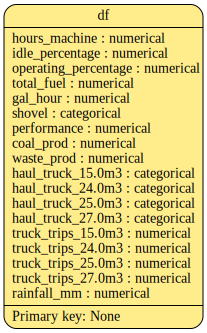

In [9]:
metadata.visualize()

In [ ]:
#metadata.save_to_json(filepath='my_metadata_v2.json') # save new metadata for future analysis

In [17]:
synthesizer = CTGANSynthesizer(
    metadata,
    epochs=1000,
    verbose=True)
synthesizer.fit(df)

Gen. (-0.41) | Discrim. (-0.22): 100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]


In [18]:
synthetic_data = synthesizer.sample(num_rows=3000)

In [19]:
synthetic_data.shape

(3000, 18)

In [20]:
dfSummary(synthetic_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,hours_machine[float64],Mean (sd) : 12.6 (4.6)min < med < max:0.2 < 11.3 < 22.1IQR (CV) : 6.3 (2.7),"2,499 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAstJREFUeJzt3bFu2kAYwPHvICADkQ1CJRtLB4ZKDBnzEH3YPkKHPAErQ8VmgZAj3Lg4trt06JAE7LNjf5f/b87FN/wVsHO+M0VRCNB1vbYnAFzjpu0JdJUxZiQiw4rDz0VRPNc5n8+OUF9hjBnN5/Pvvu/Pqox/eno6GmN+EGt9CPV1Q9/3Zw8PD89BECRlBkZR5D0+Ps4Oh8NQRAi1JoT6jiAIksVi8bvC0FHtk/nkuJmCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSowFuoDciybCAivjGmynA2r3gFodYsjuNBmqbr5XLZ7/f7pfYEEGHzircQas3O5/ON53nj+/v75O7u7lhmLJtXvI1QGzKZTNi8okbcTEEFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCs7+C9Xy+B0/z/NBnfOBHSdDtT1+J01TL8uyb0mS/BSRKv+vR82cDFUsjt8REdntdrPNZjN+eXnpNzE5lOdqqCJS/fid4/HICqYKmjzt0OlQ8XGaPu2QUFGXRk87JFTUqqnTDnmOChUIFSoQKlTgO6pjmnxE1CZCdUjTj4jaRKhuafQRUZsI1UFNPSJqEzdTUIFQoQIf/R1juROg1TraNq99CaF2iO1OgDbraNu89jUItUNsdgIUsVtH2+a1r0GoHVR1J8A61tG2ee33cDMFFQgVKhAqVOj0d1SLBRa87uyYzoZqs8CC153d09lQxWKBBa87u+diqJbrG3siklcc6+d5PgiC4Fj2cQmvO7vn3VBtPn6zLBvEcfz19vZ22+v10rLj+fjG/y79RR36vj9br9cyGo3+lPnF+/3e2263X1ar1a/pdHoqO7F/48dRFE3CMDyXGXs6nTwRkTiOvTAMx2WvbTO+rbGarx1FkXfpZ/4Ca4SEPAwfUc0AAAAASUVORK5CYII="">",0(0.0%)
2,idle_percentage[float64],Mean (sd) : 17.0 (11.3)min < med < max:0.0 < 15.2 < 82.0IQR (CV) : 11.7 (1.5),"2,956 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAqtJREFUeJzt3T1v2lAYhuH3QEgdPmwBEtmydCNSB0b2duyP7dqtQ35AmrUTC0JCBIoLwhi6lKkRxMfQ+HHvaz/Ywy1sSz6v3X6/N6DoKm99AsBrXF3yx51zN2Z2neMnNvv9fnWu84Gui4XqnLvpdrufwzBs+/7GYrGYOee+ECsu+Y96HYZhezgcrqIoWmddPJ/Pg4eHh/Z0Or02M0L9z1300m9mFkXRutfr/fJcfnPWk4EsHqYggVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAh4eLvo+aRpmnNzELnnM9ytrGUSGFDjeO4liTJh7u7u2q1Ws28Q4BtLOVS2FA3m81VEAT1wWCwvr29nWVZyzaW8ilsqAeNRsN3KwvbWEqEhylIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIOPn2VI45/OFut6t5rAP+cjTUPHP4kyQJ0jS9X6/X38zMd+I0YGan/1G95/CPRqP209NTfbvdVnOcH2Bmr3xx2mcO/2w248VlnA0PU5BAqJBAqJBAqJBAqJBAqJBQ+H39vnKOAzJjJFChlDLUvOOAzBgJVDSlDDXPOCAzRgIVUSlDPcgxDsiMkUCFwsMUJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJJT67ak8+A5rsRDqC/gOa/EQ6gv4DqufHAP1zE5chQj1CN8Xr9M0Dc3/tqFiZjufhX9433bkDC3odDqfoihq+Cw+dRV6Vajz+TzIeuDlchmYmcVxHEwmk/q/XP+Wxx6Pxy3f24Y0TWtxHL9vNps/KpVKkmXtwfPz89I599XMst6yBJ1O52MURU2f4yZJEpjZfb/f/95qtX5mWbtard49Pj4evQr9BmMfGx7lAzp9AAAAAElFTkSuQmCC"">",0(0.0%)
3,operating_percentage[float64],Mean (sd) : 84.2 (13.1)min < med < max:18.0 < 86.7 < 100.0IQR (CV) : 12.2 (6.4),"2,909 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAq5JREFUeJzt3buO2kAUgOEzsKy8XGxxEXQ06VgpBRIND5AyD7uPECSKtKGlokMgZIIDwhhSRFG2gvWMCT7W/9U7aFb6heTdOWNzuVwEyLvSozcAfMTTozeA/DDGvIjIs8NHHC+Xyz6r/bxHqBCRP5G22+2vvu83bT9ju91ujDFv94iVUPHXs+/7zfF4vA+C4JB2cRiG3nQ6ba7X62cRIVTcVxAEh263+8ty+Uumm3mHhymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKjACX9kJkmSioj4xhib5VcHAwkVmYiiqBLH8ed+v18ul8upZ65uDQYSKjJxPB6fPM+rDofDQ6/X26RZ+5HBQEJFpmq1mu1w4NXBQB6moAKhQgVChQqEChUIFSoQKlTgz1MF43B1pH8+nytZ7ycrhFogLldHxnHsJUnyejgcvomI7SVpd0OoxWJ9deRisWjOZrPq6XQq32tzLgi1gGyujtxsNne7MjILPExBBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECB6dzxmHmSSTnc08uCDVHXGaeRPI/9+SCUPPFeuZJJP9zTy4INYdsZp5E8j/35IKHKahAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSocPM/U46HJK6+NrCoinqZ7iNdDdX1kMSt1wbmmUNsXqvV+hIEQS3twiIfKnF16xvV+pBEGIbeZDLprtfrjjFma7m/koicH7DWKTYReR2NRt87nU6q37vIh0pc3e1Qyn6/d3qJa5IklSiKPtXr9XmpVIr/11qRf7ENBoMfjUbjZ5q1q9XKm8/n1SRJrGOLoshbLpfVtOt2u51nu95lrev6MAy9Wz/zGzP0COzaj9MFAAAAAElFTkSuQmCC"">",0(0.0%)
4,total_fuel[float64],Mean

### 3. Perform quality and model behavior diagnostics

In [21]:
diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 18/18 [00:00<00:00, 1225.91it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 212.17it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [22]:
quality_report = evaluate_quality(
    df,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:00<00:00, 180.76it/s]|
Column Shapes Score: 83.04%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:01<00:00, 133.76it/s]|
Column Pair Trends Score: 80.58%

Overall Score (Average): 81.81%



In [23]:
quality_report.get_details('Column Shapes').sort_values('Score', ascending=False)

,Column,Metric,Score
11,haul_truck_25.0m3,TVComplement,0.951353
9,haul_truck_15.0m3,TVComplement,0.938212
12,haul_truck_27.0m3,TVComplement,0.937752
10,haul_truck_24.0m3,TVComplement,0.912307
5,shovel,TVComplement,0.909647
1,idle_percentage,KSComplement,0.894440
3,total_fuel,KSComplement,0.891998
2,operating_percentage,KSComplement,0.882095
17,rainfall_mm,KSComplement,0.857584
15,truck_trips_25.0m3,KSComplement,0.847243


In [24]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='performance',
    metadata=metadata
)

fig.show()

In [25]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='shovel',
    metadata=metadata
)

fig.show()

In [26]:
fig = get_column_pair_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_names=['performance', 'shovel'],
    metadata=metadata
)

fig.show()

### 4. Download and merge DataFrames from real and synthetic data

In [30]:
performance_syn= pd.concat([df,synthetic_data],ignore_index=True)

In [32]:
performance_syn = performance_syn.sample(frac=1, random_state=42).reset_index(drop=True)

In [35]:
performance_syn.to_csv('performance_syn.csv', index=True)